# 5.2 Exercises: Build your own Sentiment Analysis Model
# Rahul Rajeev

In [57]:
# libraries
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB

In [3]:
# 1. Get the stemmed data
review_data=pd.read_csv('labeledTrainData.tsv',sep='\t')
review_data

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...
...,...,...,...
24995,3453_3,0,It seems like more consideration has gone into...
24996,5064_1,0,I don't believe they made this film. Completel...
24997,10905_3,0,"Guy is a loser. Can't get girls, needs to buil..."
24998,10194_3,0,This 30 minute documentary Buñuel made in the ...


In [5]:
# data transformations

# lower case
review_data['review'] = review_data['review'].str.lower()

# regex
review_data['review'] = review_data['review'].apply(lambda x: re.sub('[^A-Za-z0-9]', ' ', x))

# stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
review_data['review_without_stopwords'] = review_data['review'].apply(lambda x: ' '.join(
    [word for word in x.split() if word not in (stop)]))

# stemmed
stemmer = PorterStemmer()

def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

# creating stemmed column with the results
review_data['stemmed'] = review_data['review_without_stopwords'].apply(stem_sentences)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
review_data.head()

,id,sentiment,review,review_without_stopwords,stemmed
0,5814_8,1,with all this stuff going down at the moment w...,stuff going moment mj started listening music ...,stuff go moment mj start listen music watch od...
1,2381_9,1,the classic war of the worlds by timothy hi...,classic war worlds timothy hines entertaining ...,classic war world timothi hine entertain film ...
2,7759_3,0,the film starts with a manager nicholas bell ...,film starts manager nicholas bell giving welco...,film start manag nichola bell give welcom inve...
3,3630_4,0,it must be assumed that those who praised this...,must assumed praised film greatest filmed oper...,must assum prais film greatest film opera ever...
4,9495_8,1,superbly trashy and wondrously unpretentious 8...,superbly trashy wondrously unpretentious 80 ex...,superbl trashi wondrous unpretenti 80 exploit ...


In [9]:
# 2. Split into test and training
train, test = train_test_split(review_data, test_size=0.2)

In [13]:
# 3. fit and apply the tf-idf vectorization to the training set
tfidf = TfidfVectorizer()
# calling fit transform across every row
train_feature_matrix = tfidf.fit_transform(train['stemmed'].values)

In [14]:
train_feature_matrix.shape

(20000, 46324)

In [15]:
# 4. Apply but don't fit the tfidf to the test set
test_feature_matrix = tfidf.transform(test['stemmed'].values)

In [16]:
test_feature_matrix.shape

(5000, 46324)

We don't fit the tfidf because we use the transformed fit train values on the test set, because tfidf has some data leakage.

In [19]:
# 5. Train a logistic regression using the training data.
sentiment = train['sentiment']
sentiment.head().reset_index()

,index,sentiment
0,23134,0
1,20499,0
2,17438,0
3,21006,1
4,13005,1


In [22]:
# training model
model=LogisticRegression().fit(train_feature_matrix,sentiment)

In [23]:
# predicting from model
pred_sentiment = model.predict(train_feature_matrix)

In [27]:
# results
print(classification_report(sentiment, pred_sentiment))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      9950
           1       0.92      0.94      0.93     10050

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000



In [61]:
# 6. Find model accuracy on test set
test_sentiment = test['sentiment']
test_pred_sentiment = model.predict(test_feature_matrix)
score = model.score(test_feature_matrix, test_sentiment)
print(score)

0.8916


The model accuracy is 89% on the test data.

In [62]:
# 7. Create a confusion matrix for the test set predictions.
conf_matrix = confusion_matrix(test_sentiment, test_pred_sentiment)
conf_matrix

array([[2245,  305],
       [ 237, 2213]], dtype=int64)

In [43]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])

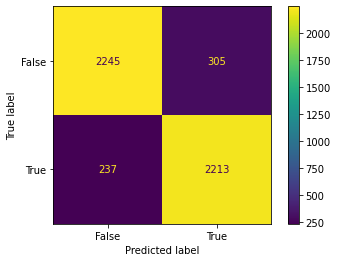

In [44]:
# visualization for fun
cm_display.plot()
plt.show()

In [46]:
# 8. Get the precision, recall, and F1-score for the test set predictions.

# used classification report
print(classification_report(test_sentiment, test_pred_sentiment))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2550
           1       0.88      0.90      0.89      2450

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



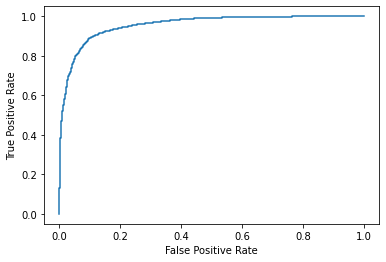

In [50]:
# 9. Create a ROC curve for the test set.
y_pred_proba = model.predict_proba(test_feature_matrix)[::,1]
fpr, tpr, _ = roc_curve(test_sentiment,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [58]:
# 10. Pick another classification model you learned about this week and repeat steps (5) – (9).

# Trying Naive Bayes
NBmodel = MultinomialNB().fit(train_feature_matrix,sentiment)

In [60]:
# 6b. Find model accuracy on test set
score = NBmodel.score(test_feature_matrix, test_sentiment)
print(score)

0.8638


In [63]:
# 7b. Create a confusion matrix for the test set predictions.
nb_test_pred_sentiment = NBmodel.predict(test_feature_matrix)

nb_conf_matrix = confusion_matrix(test_sentiment, nb_test_pred_sentiment)
nb_conf_matrix

array([[2213,  337],
       [ 344, 2106]], dtype=int64)

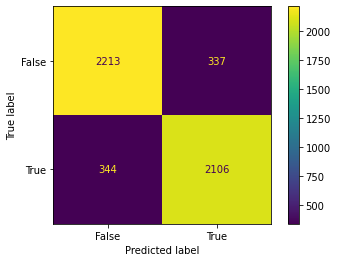

In [67]:
nb_cm_display = ConfusionMatrixDisplay(confusion_matrix = nb_conf_matrix, display_labels = [False, True])
nb_cm_display.plot()
plt.show()

In [69]:
# 8b. Get the precision, recall, and F1-score for the test set predictions.
print(classification_report(test_sentiment, nb_test_pred_sentiment))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2550
           1       0.86      0.86      0.86      2450

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



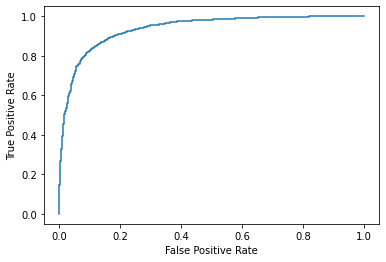

In [70]:
# 9b. Create a ROC curve for the test set.
y_pred_proba = NBmodel.predict_proba(test_feature_matrix)[::,1]
nb_fpr, nb_tpr, _ = roc_curve(test_sentiment,  y_pred_proba)

#create ROC curve
plt.plot(nb_fpr,nb_tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Thoughts:** The accuracy of the Logistic Regression model was better than the Naive Bayes multinomial model by 3%.